In [1]:
import pandas as pd
import sklearn as skl
import numpy as np
import os
import plotly.express as px
from joblib import dump, load
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from collections import Counter
from matplotlib import pyplot as plt
from time import time

#### Models used
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
def open_stata_file(filename):
    try:
        return pd.read_stata('{}/data/{}.dta'.format(os.getcwd(), filename), convert_categoricals=False)

    except Exception as e:
        print(".{} file not found".format(filename))
        print(e)
        
def new_or_not(new_se, se4):
    if new_se == 0 and se4 == 1:
        return False
    return True

### Prep Dataset

In [3]:
years = ['1415', '1516', '1617', '1718', '1819']
dfs = [pd.read_csv("./data/test_pipeline_{}.csv".format(year)) for year in years]

training_columns = ['age', 'wbhaom', 'female', 'forborn', 'citizen', 'prcitshp', 'penatvty', 'pemntvty', 'pefntvty', 'first_gen', 'married', 'children', 'hoh79',
                    'vet', 'lfstat', 'empl', 'unem', 'nilf', 'pubsect', 'union', 'multjob', 'state', 'metro', 'centcity', 'suburb', 'rural', 'educ92',
                    'college', 'ind_2d', 'ind_m03', 'docc03', 'occ_m03', 'full_time', 'paidhre', 'prhrusl', 'rw_ot', 'new_se']

fr10 = ['married', 'pubsect', 'union', 'multjob', 'state', 'ind_2d', 'docc03', 'paidhre', 'prhrusl', 'rw_ot']

for i in range(len(dfs)):
    df = dfs[i]
    df = df.loc[np.vectorize(new_or_not)(df['new_se'], df['se4'])]
    df = df[training_columns]
    df = df.replace(np.nan, 0)
    dfs[i] = df

df = pd.concat(dfs)
df = df.reset_index()
df = df.drop('index', axis=1)
print(df.shape)

/var/folders/7k/8g_2fyfx6r3gg995w1lpnnwc0000gn/T/ipykernel_8546/2500658670.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv("./data/test_pipeline_{}.csv".format(year)) for year in years]
/var/folders/7k/8g_2fyfx6r3gg995w1lpnnwc0000gn/T/ipykernel_8546/2500658670.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv("./data/test_pipeline_{}.csv".format(year)) for year in years]
/var/folders/7k/8g_2fyfx6r3gg995w1lpnnwc0000gn/T/ipykernel_8546/2500658670.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv("./data/test_pipeline_{}.csv".format(year)) for year in years]
/var/folders/7k/8g_2fyfx6r3gg995w1lpnnwc0000gn/T/ipykernel_8546/2500658670.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv("./

(388892, 37)


In [4]:
def to_csv(df, filename):
    df.to_csv('{}/data/{}.csv'.format(os.getcwd(), filename))
    print(filename + '.csv successfully saved')

In [5]:
# to_csv(df, "5yr_dataset")

5yr_dataset.csv successfully saved


In [6]:
df1 = pd.read_csv("./data/5yr_dataset.csv")
df1

,Unnamed: 0,age,wbhaom,female,forborn,citizen,prcitshp,penatvty,pemntvty,pefntvty,...,college,ind_2d,ind_m03,docc03,occ_m03,full_time,paidhre,prhrusl,rw_ot,new_se
0,0,61,2,1,0,1,1,57,57,57,...,1,40.0,10.0,8.0,2.0,1.0,0.0,4.0,20.787552,0
1,1,49,1,0,0,1,1,57,57,57,...,1,40.0,10.0,8.0,2.0,1.0,0.0,6.0,23.288980,0
2,2,19,1,0,0,1,1,57,57,57,...,0,45.0,11.0,13.0,3.0,1.0,1.0,6.0,15.678518,0
3,3,44,1,1,0,1,1,57,57,57,...,1,40.0,10.0,8.0,2.0,1.0,0.0,6.0,21.625542,0
4,4,54,1,1,0,1,1,57,57,57,...,0,17.0,4.0,20.0,8.0,0.0,1.0,4.0,16.219156,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388887,388887,57,1,1,0,1,1,57,57,57,...,0,42.0,10.0,17.0,5.0,1.0,1.0,4.0,20.362396,0
388888,388888,61,1,0,0,1,1,57,57,57,...,1,44.0,11.0,12.0,3.0,1.0,1.0,4.0,20.555840,0
388889,388889,59,1,1,0,1,1,57,57,57,...,1,49.0,12.0,6.0,2.0,1.0,0.0,4.0,19.579206,0
388890,388890,36,1,0,0,1,1,57,57,57,...,1,19.0,4.0,1.0,1.0,1.0,0.0,6.0,34.886520,0


### Undersample Datset & train_test_split

In [4]:
X = df.drop('new_se', axis=1)
y = df['new_se']
print("Population per class value: ", sorted(Counter(y).items()))

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
print("Under sampling population per class value: ", sorted(Counter(y_resampled).items()))

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=5)

Population per class value:  [(0, 376299), (1, 12593)]
Under sampling population per class value:  [(0, 12593), (1, 12593)]


### train_test_split original data

In [25]:
# X = df.drop('new_se', axis=1)
# y = df['new_se']
# print("Population per class value: ", sorted(Counter(y).items()))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

Population per class value:  [(0, 376299), (1, 12593)]


### Feature Selection

In [9]:
# clf = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=40,random_state=0)
# tic_bwd = time()
# sfs_backward = SequentialFeatureSelector(
#     clf, n_features_to_select=10, direction="backward"
# ).fit(X_train, y_train)
# toc_bwd = time()

# print("Selected Features: ")
# print(X.columns.values[sfs_backward.get_support()])
# print(f"Done in {toc_bwd - tic_bwd:.3f}s")

In [10]:
# dtc20 = X.columns.values[sfs_backward.get_support()]
# print(dtc20)

In [5]:
train_cols = ['married', 'pubsect', 'union', 'multjob', 'state', 'ind_2d', 'docc03', 'paidhre',
     'prhrusl', 'rw_ot']

# ['female' 'pefntvty' 'married' 'empl' 'pubsect' 'multjob' 'ind_2d'
#  'occ_m03' 'paidhre' 'rw_ot']

# train_cols = ['wbhaom', 'female', 'penatvty', 'pefntvty', 'married', 'children', 'vet', 'empl',
#  'nilf', 'pubsect', 'union', 'multjob', 'suburb', 'college', 'ind_2d', 'ind_m03',
#  'occ_m03', 'full_time', 'paidhre', 'rw_ot']

In [17]:
# def MyFeatureSelector(clf):
#     begin = time()
#     feature_selection = SequentialFeatureSelector(
#             clf, n_features_to_select=20, direction="backward"
#     ).fit(X_train, y_train)
#     end = time()
#     print(f"Feature selection took {end-begin}")
#     return X.columns.values[feature_selection.get_support()]

In [26]:
# algorithms = []

# # DTree
# algorithms.append(DecisionTreeClassifier(max_depth=20, max_leaf_nodes=50, random_state=0))
# # Bagged Ensemble (DTrees)
# algorithms.append(BaggingClassifier(n_estimators = 100, random_state=0, max_features=15))
# # MLP (Neural Network) Classifier
# algorithms.append(MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100,5), random_state=1, max_iter=20))
# # Random Forest
# algorithms.append(RandomForestClassifier(max_depth=20, random_state=0, max_features=20))

# # SGD Classifier
# algorithms.append(SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3))
# # Logistic Regression
# algorithms.append(LogisticRegression(random_state=0))


#### Decision Tree Clf

In [22]:
# selectedFeatures = []
# for i in range(0, 1):
#     clf = algorithms[i]
    
#     # Select features
    
#     features = MyFeatureSelector(clf)
#     selectedFeatures.append(features)
#     print(f"Selected Features: \n{features}")
    
#     # Train and Test clf
    
#     features = selectedFeatures[i]
#     clf.fit(X_train[features], y_train)
    
#     tn, fp, fn, tp = confusion_matrix(y_test, clf.predict(X_test[features])).ravel()
#     print(f"Recall: {tp/(tp+fn)}")
#     print(f"Confusion Matrix:\n tn: {tn} fn: {fn} tp: {tp} fp: {fp}")
    
#     pred = clf.predict(X_test[features])
#     print(classification_report(y_test, pred))

#### Bagged Ensemble

In [21]:
# clf = algorithms[1]
    
# # Select features
    
# features = MyFeatureSelector(clf)
# selectedFeatures.append(features)
# print(f"Selected Features: \n{features}")
    
# # Train and Test clf
    
# features = selectedFeatures[i]
# clf.fit(X_train[features], y_train)
    
# tn, fp, fn, tp = confusion_matrix(y_test, clf.predict(X_test[features])).ravel()
# print(f"Recall: {tp/(tp+fn)}")
# print(f"Confusion Matrix:\n tn: {tn} fn: {fn} tp: {tp} fp: {fp}")
    
# pred = clf.predict(X_test[features])
# print(classification_report(y_test, pred))

In [23]:
# clf = BalancedBaggingClassifier(n_estimators=100, random_state=0)

# # Select features
    
# # features = MyFeatureSelector(clf)
# # selectedFeatures.append(features)
# # print(f"Selected Features: \n{features}")
    
# # Train and Test clf
    
# features = train_cols
# clf.fit(X_train[features], y_train)
    
# tn, fp, fn, tp = confusion_matrix(y_test, clf.predict(X_test[features])).ravel()
# print(f"Recall: {tp/(tp+fn)}")
# print(f"Confusion Matrix:\n tn: {tn} fn: {fn} tp: {tp} fp: {fp}")
    
# pred = clf.predict(X_test[features])
# print(classification_report(y_test, pred))

In [24]:
# selectedFeatures = []

# for clf in algorithms:
#     features = MyFeatureSelector(clf)
#     selectedFeatures.append(features)
#     print(f"Selected Features: \n{features}")

In [25]:
# for i in range(0, len(algorithms)):
#     clf = algorithms[i]
#     features = selectedFeatures[i]
#     clf.fit(X_train[features], y_train)
    
#     tn, fp, fn, tp = confusion_matrix(y_test, clf.predict(X_test[features])).ravel()
#     print(f"Recall: {tp/(tp+fn)}")
#     print(f"Confusion Matrix:\n tn: {tn} fn: {fn} tp: {tp} fp: {fp}")
    
#     pred = clf.predict(X_test[features])
#     print(classification_report(y_test, pred))

### UnderBagging

### Decision Tree Classifier 

In [28]:
dtc = DecisionTreeClassifier(max_depth=20, max_leaf_nodes=50, random_state=0).fit(X_train[train_cols], y_train)


print("Mean Accurancy: ", dtc.score(X_test[train_cols], y_test))
prob_y = dtc.predict_proba(X_test[train_cols])
prob_y = [p[1] for p in prob_y]
print("AUROC: ", roc_auc_score(y_test, prob_y))

print("Confusion Matrix")
tn,fp, fn, tp = confusion_matrix(y_test, dtc.predict(X_test[train_cols])).ravel()
print("tn:", tn, "fn:", fn, "tp:", tp, "fp:", fp)

y_pred = dtc.predict(X_test[train_cols])
print(classification_report(y_test, y_pred))

Mean Accurancy:  0.6635569670504168
AUROC:  0.7059165442590294
Confusion Matrix
tn: 1840 fn: 995 tp: 1503 fp: 700
              precision    recall  f1-score   support

           0       0.65      0.72      0.68      2540
           1       0.68      0.60      0.64      2498

    accuracy                           0.66      5038
   macro avg       0.67      0.66      0.66      5038
weighted avg       0.67      0.66      0.66      5038



### Bagging Classification (w/ D Trees)

In [38]:
from sklearn.ensemble import BaggingClassifier
# weakClf = DecisionTreeClassifier(max_depth=20, max_leaf_nodes=50, random_state=0).fit(X_train[train_cols], y_train)
bagClf = BaggingClassifier( n_estimators = 75, random_state=0, max_features=10).fit(X_train, y_train)

print("Mean Accurancy: ", bagClf.score(X_test, y_test))
prob_y_2 = bagClf.predict_proba(X_test)
prob_y_2 = [p[1] for p in prob_y_2]
print("AUROC: ", roc_auc_score(y_test, prob_y_2))

print("Confusion Matrix")
tn,fp, fn, tp = confusion_matrix(y_test, bagClf.predict(X_test)).ravel()
print("tn:", tn, "fn:", fn, "tp:", tp, "fp:", fp)

y_pred2 = bagClf.predict(X_test)
print(classification_report(y_test, y_pred2))


Mean Accurancy:  0.684795553791187
AUROC:  0.7377241951041147
Confusion Matrix
tn: 1773 fn: 821 tp: 1677 fp: 767
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      2540
           1       0.69      0.67      0.68      2498

    accuracy                           0.68      5038
   macro avg       0.68      0.68      0.68      5038
weighted avg       0.68      0.68      0.68      5038



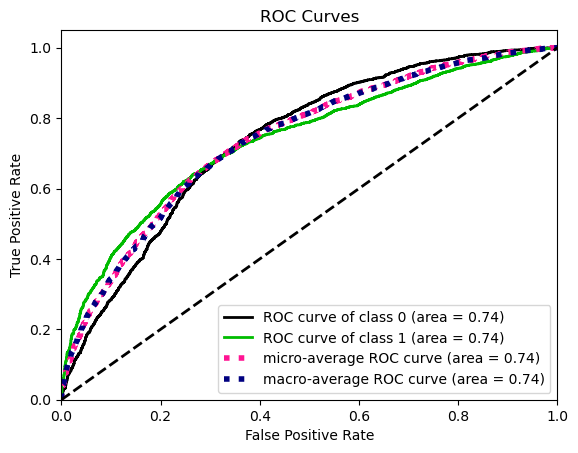

In [20]:
import matplotlib.pyplot as plt
import scikitplot as skplt
prob_y_2 = bagClf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, prob_y_2)
plt.show()

### SGD Classifier

In [14]:
from sklearn.linear_model import SGDClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline

SGDclf = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3)
SGDclf.fit(X_train[train_cols], y_train)

print("Mean Accurancy: ", SGDclf.score(X_test[train_cols], y_test))
# prob_y_2 = SGDclf.predict_proba(X_test)
# prob_y_2 = [p[1] for p in prob_y_2]
# print("AUROC: ", roc_auc_score(y_test, prob_y_2))

print("Confusion Matrix")
tn,fp, fn, tp = confusion_matrix(y_test, SGDclf.predict(X_test[train_cols])).ravel()
print("tn:", tn, "fn:", fn, "tp:", tp, "fp:", fp)

y_pred2 = SGDclf.predict(X_test[train_cols])
print(classification_report(y_test, y_pred2))

Mean Accurancy:  0.5236204843191743
Confusion Matrix
tn: 322 fn: 182 tp: 2316 fp: 2218
              precision    recall  f1-score   support

           0       0.64      0.13      0.21      2540
           1       0.51      0.93      0.66      2498

    accuracy                           0.52      5038
   macro avg       0.57      0.53      0.44      5038
weighted avg       0.58      0.52      0.43      5038



### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

LRclf = LogisticRegression(random_state=0).fit(X_train[train_cols], y_train)

print("Mean Accurancy: ", LRclf.score(X_test[train_cols], y_test))
prob_y_2 = LRclf.predict_proba(X_test[train_cols])
prob_y_2 = [p[1] for p in prob_y_2]
print("AUROC: ", roc_auc_score(y_test, prob_y_2))

print("Confusion Matrix")
tn,fp, fn, tp = confusion_matrix(y_test, LRclf.predict(X_test[train_cols])).ravel()
print("tn:", tn, "fn:", fn, "tp:", tp, "fp:", fp)

y_pred2 = LRclf.predict(X_test[train_cols])
print(classification_report(y_test, y_pred2))

Mean Accurancy:  0.6278285033743549
AUROC:  0.6697194763684964
Confusion Matrix
tn: 1719 fn: 1054 tp: 1444 fp: 821
              precision    recall  f1-score   support

           0       0.62      0.68      0.65      2540
           1       0.64      0.58      0.61      2498

    accuracy                           0.63      5038
   macro avg       0.63      0.63      0.63      5038
weighted avg       0.63      0.63      0.63      5038



/Users/jacksonp.walker/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### MLP NN Classifier

In [16]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100,5), random_state=1, max_iter=20).fit(X_train[train_cols], y_train)

print("Mean Accurancy: ", mlp.score(X_test[train_cols], y_test))
prob_y_2 = mlp.predict_proba(X_test[train_cols])
prob_y_2 = [p[1] for p in prob_y_2]
print("AUROC: ", roc_auc_score(y_test, prob_y_2))

print("Confusion Matrix")
tn,fp, fn, tp = confusion_matrix(y_test, mlp.predict(X_test[train_cols])).ravel()
print("tn:", tn, "fn:", fn, "tp:", tp, "fp:", fp)

y_pred2 = mlp.predict(X_test[train_cols])
print(classification_report(y_test, y_pred2))

Mean Accurancy:  0.6345772131798333
AUROC:  0.6848158054002257
Confusion Matrix
tn: 1813 fn: 1114 tp: 1384 fp: 727
              precision    recall  f1-score   support

           0       0.62      0.71      0.66      2540
           1       0.66      0.55      0.60      2498

    accuracy                           0.63      5038
   macro avg       0.64      0.63      0.63      5038
weighted avg       0.64      0.63      0.63      5038



/Users/jacksonp.walker/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=20, random_state=0, max_features=20).fit(X_train, y_train)

print("Mean Accurancy: ", rfc.score(X_test, y_test))
prob_y_2 = rfc.predict_proba(X_test)
prob_y_2 = [p[1] for p in prob_y_2]
print("AUROC: ", roc_auc_score(y_test, prob_y_2))

print("Confusion Matrix")
tn,fp, fn, tp = confusion_matrix(y_test, rfc.predict(X_test)).ravel()
print("tn:", tn, "fn:", fn, "tp:", tp, "fp:", fp)

y_pred2 = rfc.predict(X_test)
print(classification_report(y_test, y_pred2))

Mean Accurancy:  0.6740770146883684
AUROC:  0.7343842790768047
Confusion Matrix
tn: 1784 fn: 886 tp: 1612 fp: 756
              precision    recall  f1-score   support

           0       0.67      0.70      0.68      2540
           1       0.68      0.65      0.66      2498

    accuracy                           0.67      5038
   macro avg       0.67      0.67      0.67      5038
weighted avg       0.67      0.67      0.67      5038

